In [ ]:
# import os

# os.environ['KAGGLE_USERNAME'] = "avadhoottavhare"
# os.environ["KAGGLE_KEY"] = "820701912294d115d9f295e057aede9c"

# !kaggle datasets download -d awsaf49/ljspeech-sr16k-dataset

In [ ]:
# !unzip ljspeech-sr16k-dataset.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
cd speech_to_text

/content/drive/MyDrive/speech_to_text


In [ ]:
ls

In [ ]:
# #used to detect the accuracy of the model
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd #Creating dataframe
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import csv

In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

2748572632/2748572632 [==============================] - 137s 0us/step


In [ ]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [ ]:
#Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header =None, quoting=3)

In [ ]:
metadata_df.tail(10)

,0,1,2
13090,LJ050-0269,The essential terms of such memoranda might we...,The essential terms of such memoranda might we...
13091,LJ050-0270,This Commission can recommend no procedures fo...,This Commission can recommend no procedures fo...
13092,LJ050-0271,The demands on the President in the execution ...,The demands on the President in the execution ...
13093,LJ050-0272,and the traditions of the office in a democrac...,and the traditions of the office in a democrac...
13094,LJ050-0273,"The Commission has, however, from its examinat...","The Commission has, however, from its examinat..."
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [ ]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [ ]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

In [ ]:
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ038-0204,"According to Marina Oswald's testimony, on the..."
1,LJ007-0180,The publication of this report raised a storm ...
2,LJ015-0032,and on the other by backing up


We now splitting the data into training and validation set

In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")


Size of the training set: 11790
Size of the training set: 1310


# **Preprocessing**
We first prepare the vocabulary to be used

In [ ]:
#The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
#Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
#Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [ ]:
char_to_num

In [ ]:
# An integer scalar Tensor. The window lenght in sample
frame_length = 256
# An inegerer scalar Tensor. The number of samples to step
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If nor provided, uses the smalles of 2 enclosing frame_length
fft_length = 384

def encode_single_sample(wav_file, label):
  #Processing the audio
  #1. Read wav file
  file = tf.io.read_file(wavs_path + wav_file + ".wav")
  #2. Decode the wav file -> decode wav file to a float tensor
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1) #remove repeated tensor from the list
  #3. Change type to float
  audio = tf.cast(audio, tf.float32)
  #4. Get the spectrogram --> stft short time fourier transform
  spectrogram = tf.signal.stft (
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )
  #5. We inly need the magnitude, which can be derived by applying tf.abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  #6. normalized_transcription
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)
  ###Process the labels
  #7. Convert the label to lower case
  label = tf.strings.lower(label)
  #8. Split the label
  label = tf.strings.unicode_split(label, input_encoding = "UTF-8")
  #9. Map the characters to the label
  label = char_to_num(label)
  #10. Return a dict as out model is expecting two inputs
  return spectrogram, label

# Creating Dataset Object

We create a tf.data.Dataset object that yields the transformed elements, in the same order appeared in the input

In [ ]:
batch_size = 32
#Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)

validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

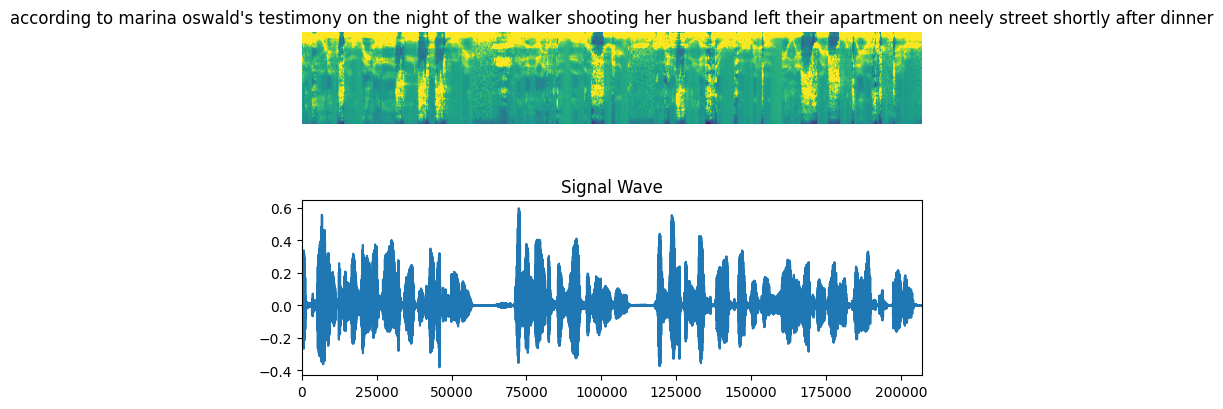

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio

fig = plt.figure(figsize=(8, 5))

# Iterating over the first batch in the training dataset
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy().flatten()

    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))

    # Display Audio
    display(Audio(np.transpose(audio), rate=16000))

    plt.show()


# Model
We first define the CTC Loss function

In [ ]:
def CTCLoss(y_true, y_pred):
  #Compute the training-time loss value
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

We now define our model. We will define a model similar to DEEPSPEECH2

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
  #Model input
  input_spectrogram = layers.Input((None, input_dim), name="input")
  #Expand the dimension to use 2D CNN
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
  #Convolution layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2,2],
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
  #Convolution Layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1, 2],
      padding="same",
      use_bias=False,
      name="conv_2",
  )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
  #Reshape the resulted volume to feed the RNNs layers
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  #RNN layers
  for i in range(1, rnn_layers + 1):
      recurrent = layers.GRU(
          units=rnn_units,
          activation="tanh",
          recurrent_activation="sigmoid",
          use_bias=True,
          return_sequences=True,
          reset_after=True,
          name=f"gru_{i}",
      )
      x = layers.Bidirectional(
          recurrent, name=f"bidirectional_{i}", merge_mode="concat"
      )(x)
      if i < rnn_layers:
          x = layers.Dropout(rate=0.5)(x)
  #Dense Layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=0.5)(x)
  #Classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
  #Model
  model = keras.Model(input_spectrogram, output, name="SpeechToText")
  #optimizer
  opt = keras.optimizers.Adam(learning_rate=1e-3)
  #Compile the model and return
  model.compile(optimizer=opt, loss=CTCLoss)
  return model

In [ ]:
#Get the model
model = build_model(
    input_dim=fft_length //2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "SpeechToText"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [ ]:
#A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    #Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    #Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

#A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
          X, y = batch
          batch_predictions = model.predict(X)
          batch_predictions = decode_batch_predictions(batch_predictions)
          predictions.extend(batch_predictions)
          for label in y:
            label = (
                tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            )
            targets.append(label)
        # wer_score = wer(targets, predictions)
        # print("-" * 100)
        # print(f"Word Error Rate: {wer_score:.4f}")
        # print("-" * 100)
        # for i in np.random.randint(0, len(predictions), 2):
        #     print(f"Target    : {targets[i]}")
        #     print(f"Prediction: {predictions[i]}")
        #     print("-" * 100)

Let's start the training process

In [ ]:
# Training the model
epochs = 15
validation_callback = CallbackEval(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/15
369/369 [==============================] - 2306s 6s/step - loss: 325.3429 - val_loss: 306.8358
Epoch 2/15
369/369 [==============================] - 1081s 3s/step - loss: 296.9262 - val_loss: 303.9894
Epoch 3/15
369/369 [==============================] - 1019s 3s/step - loss: 296.0446 - val_loss: 299.7997
Epoch 4/15
369/369 [==============================] - 1043s 3s/step - loss: 295.5012 - val_loss: 300.9305
Epoch 5/15
369/369 [==============================] - 1081s 3s/step - loss: 272.9804 - val_loss: 215.8806
Epoch 6/15
369/369 [==============================] - 1013s 3s/step - loss: 156.6291 - val_loss: 106.0440
Epoch 7/15
369/369 [==============================] - 1019s 3s/step - loss: 100.5022 - val_loss: 77.3348
Epoch 8/15
369/369 [==============================] - 1045s 3s/step - loss: 79.8722 - val_loss: 65.1284
Epoch 9/15
369/369 [==============================] - 1077s 3s/step - loss: 69.3236 - val_loss: 59.0575
Epoch 10/15
369/369 [==============================

# Inference

In [ ]:
# Save the entire model to Google Drive
model.save('/content/drive/MyDrive/speech_to_text/speech_to_text_model')

# Save the model weights
model.save_weights('/content/drive/MyDrive/speech_to_text/speech_to_text_model_weights')

# Save the model architecture as JSON
model_json = model.to_json()
with open('/content/drive/MyDrive/speech_to_text/speech_to_text_model.json', 'w') as json_file:
    json_file.write(model_json)

# Save training history to analyze later or plot
import pickle
with open('/content/drive/MyDrive/speech_to_text/training_history.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)


In [ ]:
# Save the entire model
model.save('/content/speech_to_text_model')

# Save the model weights
model.save_weights('/content/speech_to_text_model_weights')

# Save the model architecture as JSON
model_json = model.to_json()
with open('/content/speech_to_text_model.json', 'w') as json_file:
    json_file.write(model_json)

# Save training history to analyze later or plot
import pickle
with open('/content/training_history.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)


In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)  # Fix: Use X instead of x
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)  # Fix: Use targets instead of target




1/1 [==============================] - 1s 609ms/step


In [ ]:
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")  # Fix: Add precision to format specifier
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3673
----------------------------------------------------------------------------------------------------
Target    : since the assassination secret service procedures have been changed to require that a member of prs accompany each advance survey team
Prediction: since the assassination secret service procedurs have been changed to requar that a member of prs a company each ed vance servat
----------------------------------------------------------------------------------------------------
Target    : and received his sentence of transportation for life without much surprise
Prediction: and received his sentece of transportation for life without much supros
----------------------------------------------------------------------------------------------------
Target    : as mcdonald started to search oswald's waist for a gun he heard him say quote well it's all over now 

In [ ]:
# Save the entire model to an HDF5 file
model.save('/content/model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
